<a id='contents'><h2>Contents</h2></a>

[Getting images out of Doug's raster pipeline](#dougOut)

[Digitizing polygons](#digPol)
- [Digitizing with scikit-image](#skimmage)  
    - [Get petal and spot polygons](#getPolys)
    - [Standardizing polygon and spots](#standPol)
    - [Get corner points](#corners)
    - [Testing outputs in Matlab](#matTest)  
    - [summary of python image processing](#pySum)
[Get back to Matlab](#Py2Mat)

[Messing around with polygons](#messAround)



---
<a id='dougOut'><h3>Getting images out of Doug's raster pipeline</h3></a>

Let's dive back into the process of making polygons from Doug's processed photos. Flower photos were broken into their various petals of interest, and color differences were maximized by categorizing all pixels into three color poles using kmeans clustering. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

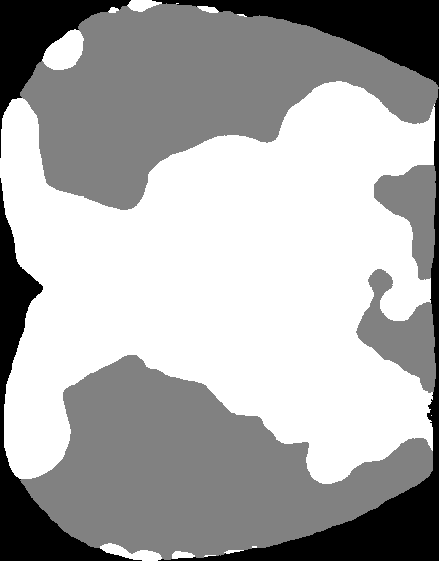

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

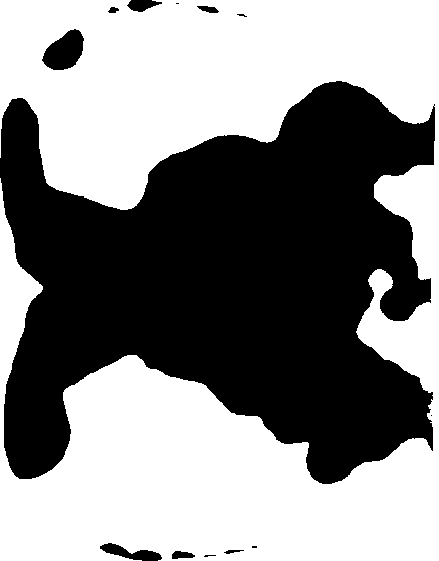

In [2]:
bb = aa < 1;
imshow(bb);


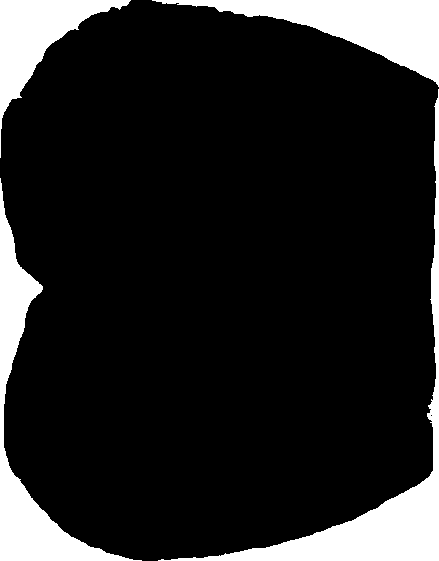

In [3]:
cc = aa == 0;
imshow(cc);

We save these and export them for gimp...

In [4]:
imwrite(bb, 'P431F1_bottom_spots.png')
imwrite(cc, 'P431F1_bottom_petal.png')

We can generalize the above process, to get all of the available photos from Doug's efforts into a form ready to digitized. I wrote a matlab script for this:

In [1]:
cat prepDougRasters.m

%%%%%%%%%%%%%%%%%%%%%%%%%%

%% a script to put all of Doug's rasters into a form we can use:

%% go to working directory
wd = '/Users/danthomas/Documents/speckling/make_polygons/polygons/';
cd(wd);

dougRasterDir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";

cd(dougRasterDir)

files = dir('P*.mat');
for file = files';
    im = file.name;
    imName = regexprep(im,'\.mat', ''); 
    %% go get our file, come back
    cd(dougRasterDir);
    rast=load(im);
    cd(wd);
    %% make a spot for our image, go to it:
    mkdir(imName);
    cd (imName);
    %% get our petal names (left, right mid)
    petNames = fieldnames(rast.Petals.Clusters);
    %% split images into petal and spot, export, for each of the three petals:
    for i = 1:length(petNames);
        pet = rast.Petals.Clusters.(petNames{i}); %petal at hand
        rastGray = mat2gray(pet); 
        spots = rastGray  < 1; 
        petal = rastGray == 0;
        mkdir(petNames{i});
        cd(petNames{i});
 

This is brittle code, if the file architecture of the repo or the shape of Doug's matlab structures changes, it will break. But most of it should be useful/re-useable, so including it here. 

---

<a id='digPol'><h3>Digitizing polygons</h3></a>

<a id='skimmage'><h4>Digitizing with scikit-image</h4></a>

Let's see if a quick dip into python, in particular [scikit-image](https://scikit-image.org/), can help us. And shapely, the standard package for manipulating polygons in python. 

But first, let's get example images out of matlab/octave again:

In [1]:
## in octave:
pkg load image

## get one grayscale image:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
aa = mat2gray(Petals.Clusters.right);

## remake our images:
spots = aa < 1;

petal = aa == 0;

## save them as csv's:

csvwrite('P431F1petal.csv',petal)
csvwrite('P431F1spots.csv',spots)

<h5><a id='getPolys'>Get petal and spot polygons</a></h5>

Back into python, let's get the petal and spots from these images, by tracing their outlines.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.affinity as sa
from skimage import measure
from descartes import PolygonPatch

Our first step is to trace the contours of our petals and spots. Here's a function that reads in one of these csvs from Doug, and turns it into a n x 2 array that can be used as polygon vertices, useful for petal or spots:

In [28]:
def digitizePols(file):
    ## pad margins of image and get the contour of the petal shape
    petal = np.genfromtxt (file, delimiter=",")
    petal_marg = np.insert(petal, petal.shape[1], 1, 1)
    petal_marg = np.insert(petal_marg, 0, 1, 1)
    petal_marg = np.insert(petal_marg, petal.shape[0], 1, 0)
    petal_marg = np.insert(petal_marg, 0, 1, 0)
    Pcontours = measure.find_contours(petal_marg, 0)
    ## gotta ditch <3 points, they are lines
    polys = [ i for i in Pcontours if len(i) > 3 ]
    return(polys)

We need to look at our raw petal outline first, to create a reference for centering and scaling (standardizing) the petal and spots. This function gets the information (centroid, scaling constant) we need to do that:

In [29]:
def getPetGeoInfo(pet):
    aa = sg.asPolygon(pet)
    area = aa.area
    scalar = area**(-1/2)
    center = aa.centroid
    centerCoor = (center.x, center.y)
    return(scalar, centerCoor)

With this info, we can craft a function to "standardize" our petals and our spots. In our case, that means center the petal and the array of spots to the origin, scale the petal polygon to area =1, and scale the spots by this same ratio:

In [30]:
def stand(pol, scale, cent):
    aa = sg.asPolygon(pol)
    trans = sa.translate(aa, (-1*cent[0]), (-1*cent[1]))
    scaled = sa.scale(trans, xfact=scale, yfact=scale, origin = (0,0))
    return(scaled)

We can also define three zones of interest - center, margin and petal. We define the proportion ('percent') of petal we would like to remain as "center", and the rest is given to the margin and throat:

In [46]:
def findZones(standPol, percent):
    center = standPol
    rad = 0
    while center.area > percent:
        center = standPol.buffer(rad)
        rad -= .001
    marg = sg.polygon.Polygon(
            standPet.exterior,
            holes = [center.exterior.coords])
    simPol = marg.simplify(0.05)
    simPolA = np.array(simPol.exterior.xy).transpose()
    simPolA[:,0].argsort()
    simPolAsorted = simPolA[simPolA[:,1].argsort()[::-1]]
    outCorners = simPolAsorted[0:2]
    simPolB = np.array(simPol.interiors[0].xy).transpose()
    simPolB[:,0].argsort()
    simPolBsorted = simPolB[simPolB[:,1].argsort()[::-1]]
    inCorners = simPolBsorted[0:2,]
    inCorners = np.flipud(inCorners)
    tRap = np.concatenate((outCorners,inCorners))
    tRapPoly = sg.polygon.Polygon(tRap)
    tBuff = tRapPoly.buffer(0.1)
    noTrap = marg.difference(tRapPoly)
    notInTrap = [ i for i in noTrap if i.within(tBuff) ]
    mpNotInTrap = sg.multipolygon.MultiPolygon(notInTrap)
    margInTrap = tRapPoly.intersection(marg)
    throat = margInTrap.union(mpNotInTrap )
    edge = marg.difference(throat)
    return(center, edge, throat)

With these functions, we can take the petal and spots from doug's rasters and make some standardized petal and spot polygons:

In [47]:
## we have an example "right" or lower petal example in our wd:
petalFile=('P431F1petal.csv')
spotsFile=('P431F1spots.csv')

## 1 make our raw, unscaled, untranslated polygons:
testP = digitizePols(petalFile)[0] ## for petals, take first polygon, always seems to work?
testS = digitizePols(spotsFile)

## 2 get information about centroid and scaling factor:
scale, cent = getPetGeoInfo(testP)

## 3 standardize petals
standPet = stand(testP, scale, cent)

## 4 standardize spots
spotz = [ stand(i, scale, cent) for i in testS ]

## 5 define zones, at 50%:
center, edge, throat = findZones(standPet, 0.5)

In [33]:
plt.rcParams['figure.figsize'] = [15, 5]

Did this work?

1.0000000000000029 1.0000000000000002


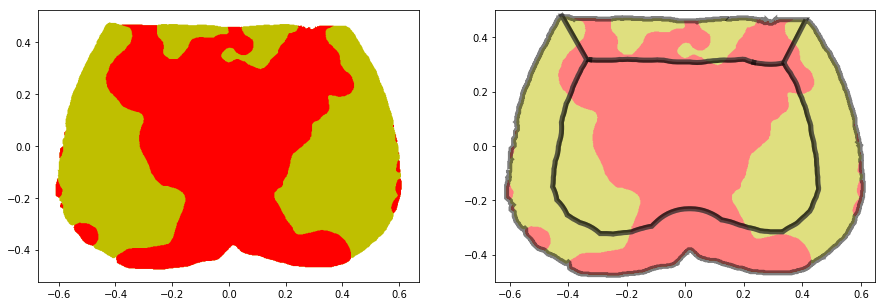

In [68]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
xs, ys = standPet.exterior.xy
ax1.fill(xs, ys, "y")
for i in spotz:
    xs, ys = i.exterior.xy
    ax1.fill(xs, ys, "r")
    
ax2.set_xlim(-.65,.65)
ax2.set_ylim(-0.5,0.5)

xs, ys = standPet.exterior.xy
ax2.fill(xs, ys, "y")
for i in spotz:
    xs, ys = i.exterior.xy
    ax2.fill(xs, ys, "r")

alp=0.5
l=5

ax2.add_patch(PolygonPatch(center, fc='white', ec='black', linewidth=l, alpha=alp))
ax2.add_patch(PolygonPatch(throat, fc='white', ec='black', linewidth=l, alpha=alp))
ax2.add_patch(PolygonPatch(edge, fc='white', ec='black', linewidth=l, alpha=alp))
    
## check area. = 1?

zoneAreas = center.area + throat.area + edge.area 
print(standPet.area, zoneAreas) 

We have a petal area = 1, and petal centroid is on the origin. Zones are coming along. Generally, looks good. 

<h5><a id='matTest'>Testing outputs in Matlab</a></h5>

Are these in a format that Matlab/Octave can parse? Back into Matlab:

In [15]:
%% switch to Matlab kernel
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

In [17]:
a=csvread('P431F1bottomspots6_poly.csv');
b=polyshape(a) %% doesn't like that we repeat our last vertex, but deals with it

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

b = 

  polyshape with properties:

      Vertices: [971x2 double]
    NumRegions: 1
      NumHoles: 0



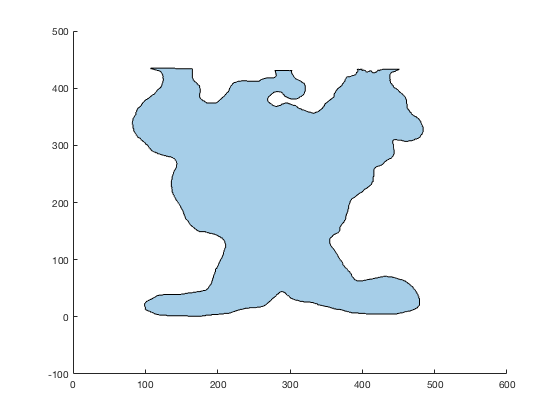

In [19]:
plot(b)

Okay! looks like matlab can parse our polygons that we make with python. Let's go back and make a nicer script that can handle some volume and that can be run from the command line...

This script is saved in the repo, but here's a look at it:

In [12]:
#cat get_pols.py

Error: Invalid text character. Check for unsupported symbol, invisible character, or pasting of non-ASCII characters.



So we can run this on one of our black-and-white CSVs that we got from doug's pipeline [(above)](#dougOut)

`./get_pols.py P431F1spots.csv` 

`./get_pols.py P431F1petals.csv`

This creates two folders one with polygons from our spots, and one with just one file, of the outline of our petal. Let's look at them with Matlab:

In [7]:
%% switch to Matlab kernel
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

In [1]:
%% some name variables, trying to set up for scripting a function 
wkd = '/Users/danthomas/Documents/speckling/make_polygons/';
name='P431F1spots';

cd(wkd);
cd(name);

We can read in those csvs we just made in python:

In [4]:
aa = struct;
counter = 1;
files = dir('*.csv');
for file = files';
    coords = csvread(file.name);
    aa(counter).coords=coords;
    counter = counter + 1;
end;

For spots with enough points we can turn these into polygons. As before, polyshape() doesn't like the fact that scikit-image closes it's polygons with a repeated last vertex. But it deals with it:

In [5]:
counter=1;
for i = aa;
    if length(i.coords(:,1)) > 3;
        aa(counter).p = polyshape(i.coords)
    end;
    counter=counter+1;
end;

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 411)
  In polyshape (line 155)
> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimpl

Plot these:

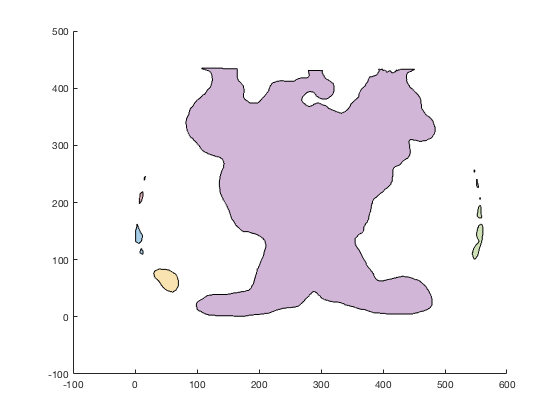

In [8]:
counter=1;
for i = aa;
    if ~isempty(i.p)
        plot(i.p)
        hold on %% keep the plot open
    end;
    counter=counter+1;
end;

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)


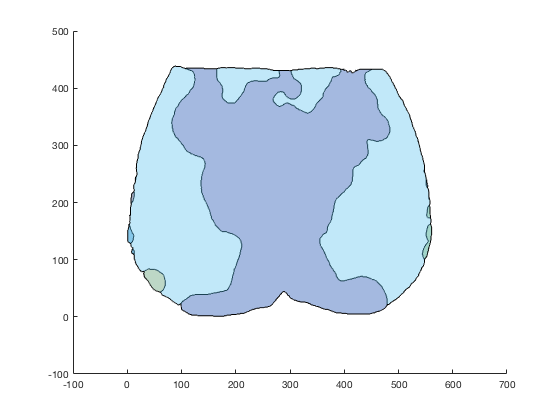

In [10]:
%% add our petal outline:

counter=1;
for i = aa;
    if ~isempty(i.p)
        plot(i.p)
        hold on %% keep the plot open
    end;
    counter=counter+1;
end;

Pcoords = csvread("/Users/danthomas/Documents/speckling/make_polygons/P431F1petal/P431F1petal_poly0.csv");
Ppoly = polyshape(Pcoords);
plot(Ppoly)


Lots work to be done, and some decisions to be made. Some tiny spots are being lost - how much do we care about this little ones? This needs to be talked about. But to apply our script across the numerous images, in the file architecture of my repo, we start a new container directory, put a copy of get_pols.py in it and use `find`.

In [ ]:
#find ../polygons/ -name "P*csv" -type f  -exec ./get_pols.py {} \;

<a id='Py2Mat'><h3>Get back to Matlab</h3></a>

The result is a LOT of .csv files (1000's)! Let's simplify by combining into substructures of Doug's existing Matlab structures for these images. In matlab:

In [ ]:
wd = '/Users/danthomas/Documents/speckling/make_polygons/';
petNames = ["left", "mid", "right"];
typPols = ["petal", "spots"];

%% go to the images/structures folder and get out a list of all the *mat files:
cd(dougdir)
hs = dir('P*.mat');
for h = hs'; %% for each mat file:
    im = regexprep(h.name,'\.mat', '');
    cd(wd)
    Polys = struct; %% empty struct to hold the polyshapes
    for i = petNames; %% left, mid, right
        for j = typPols; %% petal/spots
            imdir = "tryScript/" + im + "_" + i + "_" + j; %% this is where all our csvs are
            cd(imdir);
            files = dir('P*.csv');
            counter = 1;
            for file = files';
                disp(file.name)
                disp(counter)
                coords=csvread(file.name);
                if length(coords(:,1)) > 3; %% if there are enough points
                    Polys.(i).(j)(counter) = polyshape(coords); %% convert to polyshape
                    counter=counter+1;
                end;
            end;
        cd(wd)
        end;
    end;
    load(dougdir + im + ".mat"); %% get doug's matlab structure
    Petals.Polys = Polys; %% add our new Polys structure inside it
    imFile = wd + "matObjW_pol/" + im + ".mat"; %% save the modified structure
    save(imFile,"Petals");
end;


This adds our polygons as fields to dougs original matlab structure objects. Just to pick one and visualize:

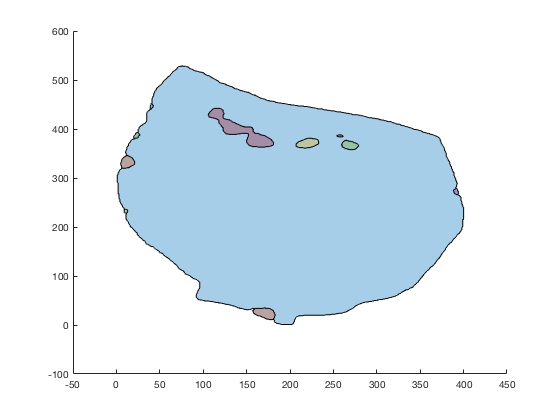

In [2]:
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter
load("/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol/P440F1.mat")

%% iterate through our petal outline and spots

for i = Petals.Polys.left.petal
    if ~isempty(i)
        plot(i)
        hold on %% keep the plot open
    end;
end;

for i = Petals.Polys.left.spots
    if ~isempty(i)
        plot(i)
        hold on %% keep the plot open
    end;
end;

We want some nice graphical summary of this pipeline, from jpeg to Doug's 3-color objects to these petal/spot polygons. Something like:

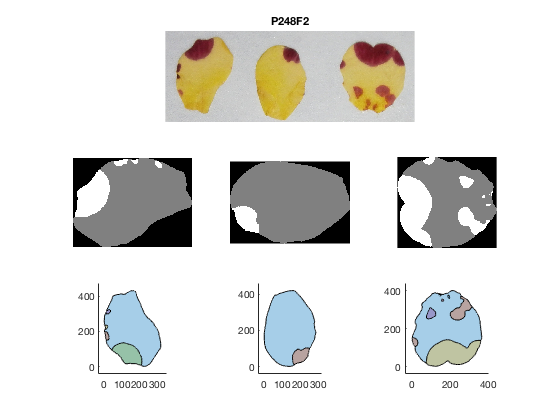

In [3]:
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

%% get the working env organized:
wd="/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol";
cd(wd);
load('P248F2.mat');
dougdir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";
[a,b,c] = fileparts(Petals.fullName);
jpegName = char(dougdir + b + c); %% gotta be a character object?

%% plot a page:
    figure;
    %%%%%%%%% first row %%%%%%%%%%%%%%%
    subplot(3,3,[1,3]);
    imshow(jpegN);
    title(b) %% this is our plot title
    %%%%%%%%% second row %%%%%%%%%%%%%
    subplot(3,3,4);
    aa = mat2gray(Petals.Clusters.left);
    imshow(aa)
    subplot(3,3,5);
    aa = mat2gray(Petals.Clusters.mid);
    imshow(aa)
    subplot(3,3,6);
    aa = mat2gray(Petals.Clusters.right);
    imshow(aa)
    %%%%%%%%%% third row %%%%%%%%%%%%%%
    subplot(3,3,7);
        if isfield(Petals.Polys.left,'petal');
        for i = Petals.Polys.left.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.left,'spots');
        for i = Petals.Polys.left.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    subplot(3,3,8);
        if isfield(Petals.Polys.mid,'petal');
        for i = Petals.Polys.mid.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.mid,'spots');
        for i = Petals.Polys.mid.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    subplot(3,3,9);
        if isfield(Petals.Polys.right,'petal');
        for i = Petals.Polys.right.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.right,'spots');
        for i = Petals.Polys.right.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    %%%%%%%%%%%%%%

True matlab programmers will gag at this. But I'm no matlab programmer, I have no standards. Onward - I used something like this to make a pdf summary of the above pipeline, script for this is called "plotPDFsummary.m", in this repo. 